In [135]:
import pandas as pd

# source: https://www.kaggle.com/datasets/jcblaise/imdb-sentiments?select=train.csv
df = pd.read_csv("data/imdb_movie_sentiment.csv")
df.head(3)

,text,sentiment
0,For a movie that gets no respect there sure ar...,0
1,Bizarre horror movie filled with famous faces ...,0
2,"A solid, if unremarkable film. Matthau, as Ein...",0


In [ ]:
text_column = "text"
label_column = "sentiment"

limit = 10000
# TODO: sample from the dataframe using the `limit` variable

df[text_column] = df[text_column].str.lower()

In [137]:
df[label_column].value_counts()

sentiment
0    5038
1    4962
Name: count, dtype: int64

In [138]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df[text_column],
    df[label_column],
    test_size=0.2,
    random_state=42,
    stratify=df[label_column],
)


tfidf = TfidfVectorizer()
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

# make predictions
y_pred = model.predict(X_test_vec)

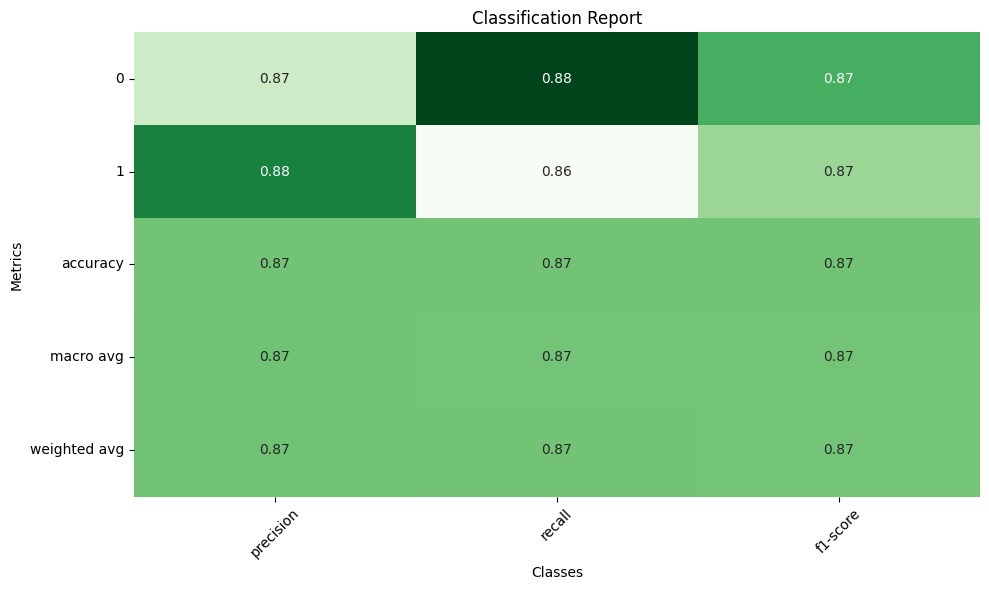

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_classification_report(y_test, y_pred):
	cr = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

	fig, ax = plt.subplots(figsize=(10, 6))
	sns.heatmap(
		pd.DataFrame(cr).iloc[:-1, :].T,
		annot=True,
		fmt=".2f",
		cmap="Greens",
		cbar=False,
		ax=ax,
	)
	ax.set_title("Classification Report")
	ax.set_xlabel("Classes")
	ax.set_ylabel("Metrics")
	plt.xticks(rotation=45)
	plt.yticks(rotation=0)
	plt.tight_layout()
	plt.show()

draw_classification_report(y_test, y_pred)


array([[0.88095238, 0.11904762],
       [0.1391129 , 0.8608871 ]])

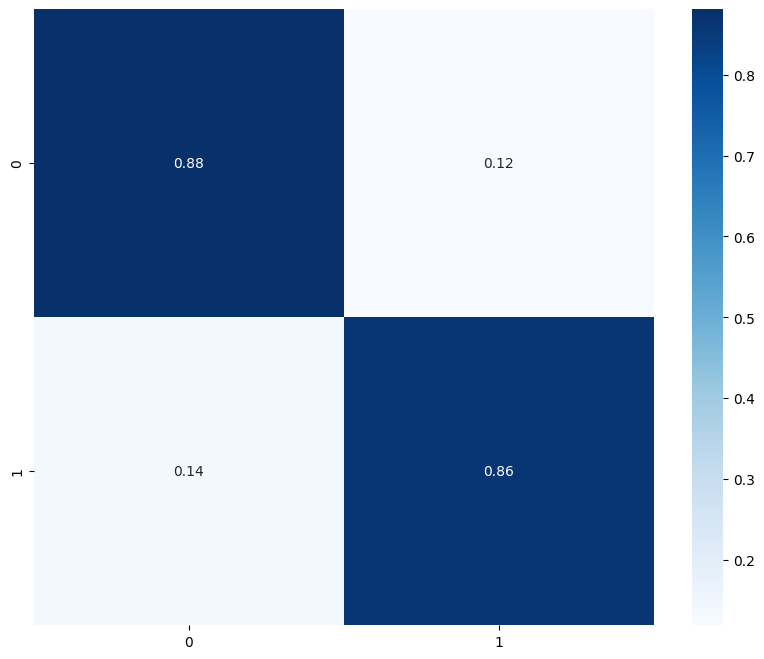

In [140]:

import seaborn as sns
import matplotlib.pyplot as plt

def draw_confusion_matrix(y_true, y_pred):
	cm = confusion_matrix(y_test, y_pred, normalize="true")

	# draw confusion matrix
	plt.figure(figsize=(10, 8))
	sns.heatmap(
		cm,
		annot=True,
		fmt=".2f",
		cmap="Blues",
	)
	return cm

draw_confusion_matrix(y_test, y_pred)


## Train a feedforward network using glove embeddings

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchtext.vocab import GloVe


class GloveModel(nn.Module):
    def __init__(self, embed_dim, num_classes):
        super(GloveModel, self).__init__()
        global_vectors = GloVe(name='6B', dim=embed_dim)
        glove_weights = torch.load(f".vector_cache/glove.6B.{embed_dim}d.txt.pt")

        # TODO: update the freeze parameter and observe the difference when training the model
        # freeze = True means that the weights of the embedding layer will not be updated during training
        self.embedding = nn.Embedding.from_pretrained(glove_weights[2], freeze=True)
        self.linear1 = nn.Linear(embed_dim, num_classes)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.embedding(x)
		# 20% of matrix cells become zero
        x = self.dropout(x)
		# TODO: take the maximum of the embedding matrix (1 dimension)
        x = x.max(dim=1)[0]
		# project to the number of classes
        out = self.linear1(x)
        return out

In [ ]:
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder

# Define hyperparameters
embed_dim = 50
num_classes = 2
learning_rate = 0.01
num_epochs = 10
batch_size = 64
early_stopping_patience = 5


model = GloveModel(embed_dim=embed_dim, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Prepare data for training
def preprocess_text(texts, vocab):
    return [
        torch.tensor([vocab.stoi[word] for word in text.split() if word in vocab.stoi],dtype=torch.long)
        for text in texts
    ]

# 3 way split
# TODO: split the data into train, validation and test sets

# encode tokens to indices
global_vectors = GloVe(name="6B", dim=embed_dim)
X_train_indices = preprocess_text(X_train, global_vectors)
X_val_indices = preprocess_text(X_val, global_vectors)

# pad with zeros to fill missing values
X_train_padded = pad_sequence(X_train_indices, batch_first=True)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val = pad_sequence(X_val_indices, batch_first=True)
y_val = torch.tensor(y_val.tolist(), dtype=torch.long)

epoch_acc = []

epoch_train_loss = []
epoch_val_loss = []

# Training loop
for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    n_batches = len(X_train_padded) // batch_size

    for i in tqdm(
        range(0, len(X_train_padded), batch_size), desc="Batches", unit="batch"
    ):
        batch_X = X_train_padded[i : i + batch_size]
        batch_y = y_train_tensor[i : i + batch_size]

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    epoch_train_loss.append(epoch_loss /  n_batches)
    train_accuracy = correct / total

    model.eval()
    with torch.no_grad():
        # TODO: get loss and accuracy on the validation set
        # add these values to the epoch_val_loss and epoch_acc lists

        # stop training if accuracy does not improve
        if len(epoch_acc) > early_stopping_patience and max(epoch_acc[:-early_stopping_patience]) >= val_accuracy:
            break
    
    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}"
    )
    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}"
    )

Epochs:  10%|█         | 1/10 [00:04<00:44,  4.96s/epoch]

Epoch [1/10], Val Loss: 0.6767, Val Accuracy: 0.5831
Epoch [1/10], Loss: 69.6984, Accuracy: 0.8635


Epochs:  20%|██        | 2/10 [00:08<00:33,  4.14s/epoch]

Epoch [2/10], Val Loss: 0.6623, Val Accuracy: 0.6138
Epoch [2/10], Loss: 67.1966, Accuracy: 0.8635


Epochs:  30%|███       | 3/10 [00:11<00:24,  3.50s/epoch]

Epoch [3/10], Val Loss: 0.6565, Val Accuracy: 0.6175
Epoch [3/10], Loss: 66.1939, Accuracy: 0.8635


Epochs:  40%|████      | 4/10 [00:14<00:19,  3.27s/epoch]

Epoch [4/10], Val Loss: 0.6529, Val Accuracy: 0.6231
Epoch [4/10], Loss: 65.7876, Accuracy: 0.8635


Epochs:  50%|█████     | 5/10 [00:16<00:15,  3.04s/epoch]

Epoch [5/10], Val Loss: 0.6527, Val Accuracy: 0.6175
Epoch [5/10], Loss: 65.1088, Accuracy: 0.8635


Epochs:  60%|██████    | 6/10 [00:19<00:11,  2.91s/epoch]

Epoch [6/10], Val Loss: 0.6489, Val Accuracy: 0.6294
Epoch [6/10], Loss: 65.2134, Accuracy: 0.8635


Epochs:  70%|███████   | 7/10 [00:22<00:08,  2.80s/epoch]

Epoch [7/10], Val Loss: 0.6487, Val Accuracy: 0.6275
Epoch [7/10], Loss: 65.0727, Accuracy: 0.8635


Epochs:  80%|████████  | 8/10 [00:24<00:05,  2.73s/epoch]

Epoch [8/10], Val Loss: 0.6462, Val Accuracy: 0.6369
Epoch [8/10], Loss: 65.0927, Accuracy: 0.8635


Epochs:  90%|█████████ | 9/10 [00:27<00:02,  2.75s/epoch]

Epoch [9/10], Val Loss: 0.6491, Val Accuracy: 0.6244
Epoch [9/10], Loss: 65.1893, Accuracy: 0.8635


Epochs: 100%|██████████| 10/10 [00:30<00:00,  3.00s/epoch]

Epoch [10/10], Val Loss: 0.6475, Val Accuracy: 0.6262
Epoch [10/10], Loss: 65.0963, Accuracy: 0.8635


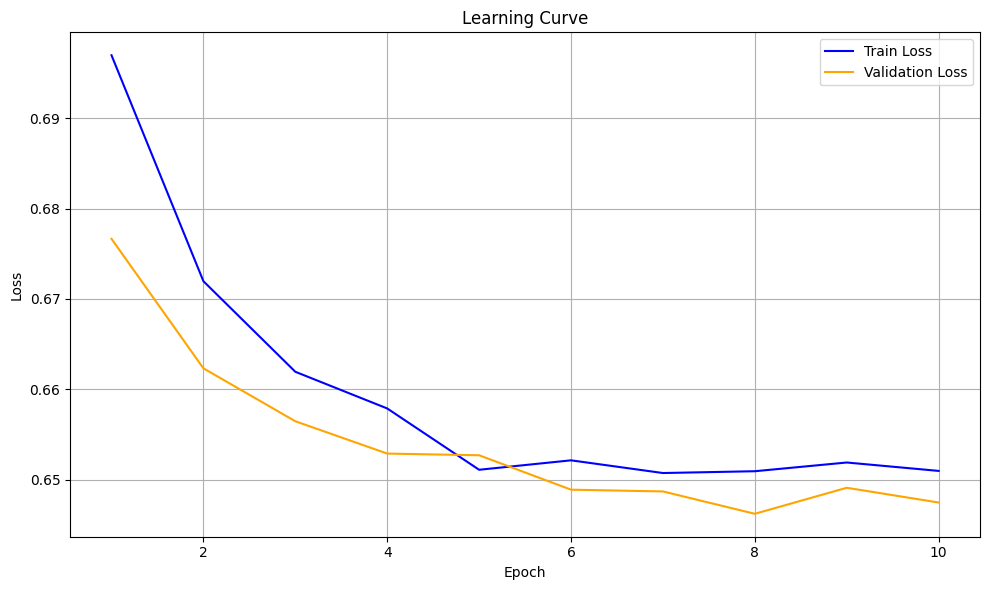

In [154]:

def draw_learning_curve(train_loss, val_loss):
	plt.figure(figsize=(10, 6))
	plt.plot(range(1, len(train_loss) + 1), train_loss, label="Train Loss", color="blue")
	plt.plot(range(1, len(val_loss) + 1), val_loss, label="Validation Loss", color="orange")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.title("Learning Curve")
	plt.legend()
	plt.grid()
	plt.tight_layout()
	plt.show()

draw_learning_curve(
	train_loss=epoch_train_loss,
	val_loss=epoch_val_loss
)

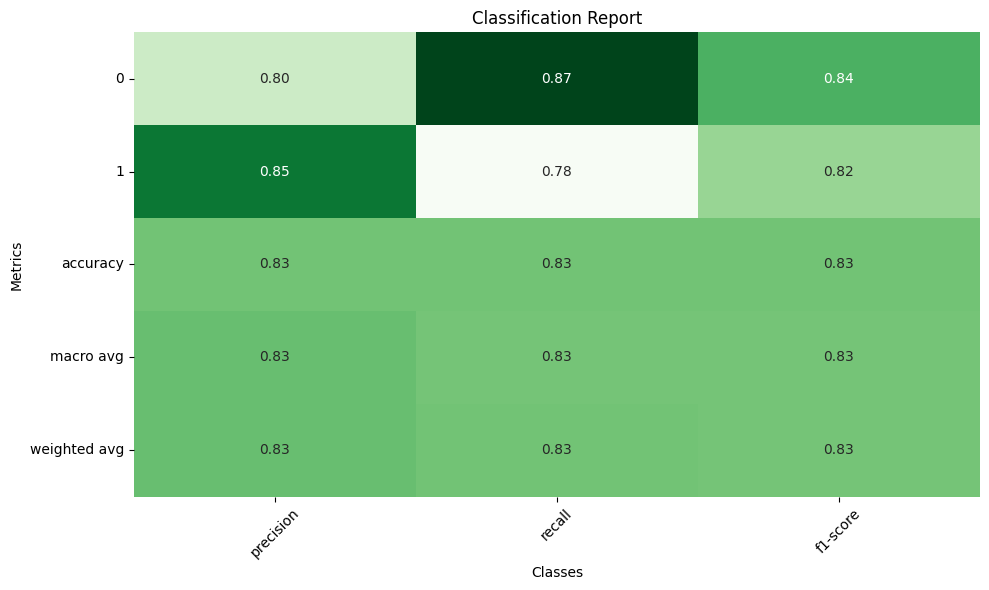

In [149]:
# predict on test set
model.eval()
X_test_indices = preprocess_text(X_test, global_vectors)
X_test_padded = pad_sequence(X_test_indices, batch_first=True)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.long)
y_pred_tensor = model(X_test_padded)
_, y_pred = torch.max(y_pred_tensor, 1)
# Convert predictions to numpy array
y_pred = y_pred.detach().numpy()
# Convert y_test_tensor to numpy array
y_test = y_test_tensor.detach().numpy()

draw_classification_report(y_test, y_pred)


array([[0.81845238, 0.18154762],
       [0.28528226, 0.71471774]])

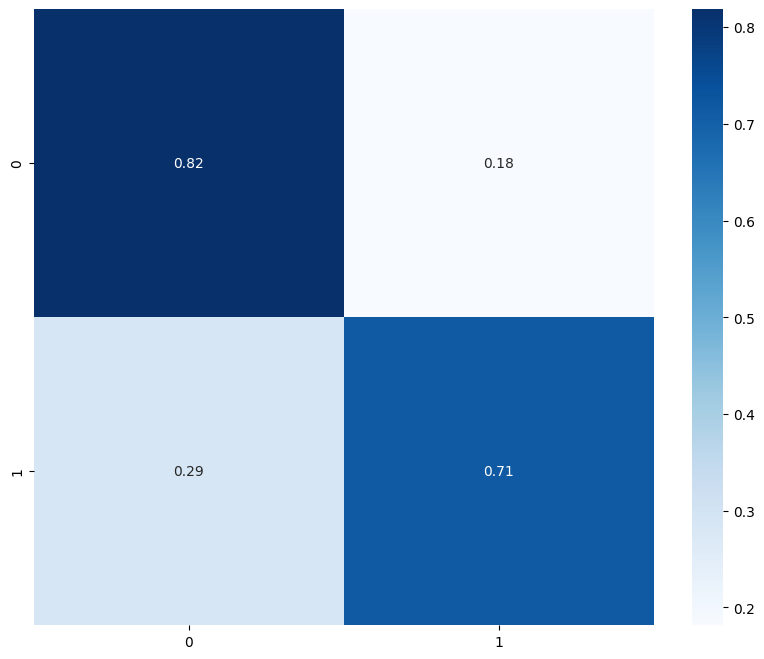

In [145]:
draw_confusion_matrix(y_test, y_pred)